### Step1 - 导入相关包 & 初始化设置

In [ ]:
import os, sys

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
# 常用的消息类型
from langchain.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage, AIMessageChunk
# 利用 checkpointer 来提供短期记忆能力
from langgraph.checkpoint.memory import InMemorySaver
# 中间件, 用于总结历史对话内容
from langchain.agents.middleware import SummarizationMiddleware

# 默读取当前目录下的 .env 文件, 可以通过 dotenv_path 来修改
from dotenv import load_dotenv
# 这种写法可以规避在 vscode 中找不到 .env 的问题
current_dir = os.path.dirname(os.getcwd())
load_dotenv(dotenv_path=os.path.join(current_dir, "../.env"))

# 记录日志
from loguru import logger
logger.remove()
logger.add(sys.stderr, level=os.getenv("LOG_LEVEL"))

1

### Step2 - 和记忆相关的设定

In [2]:
# 定义一个 checkpointer (保存在内存中)
checkpointer = InMemorySaver()
# 如果需要会话隔离, 可以传递一个 config 参数, 里面需要指定 thread_id
config = {"configurable": {"thread_id": "1"}}

### Step3 - 创建 Agent 智能体

In [3]:
# 创建 ChatModel: v1 创建聊天模型的方法
chat_model = init_chat_model(
    model_provider="ollama",
    # model 也可以写为 <model_provider>:<model_name> 的形式
    # 这样就可以不用指定 model_provider 这个参数了
    model = os.getenv("OLLAMA_LLM_MODEL"),
    base_url = os.getenv("OLLAMA_BASE_URL"),
    max_tokens = 4096,
)
chat_model

ChatOllama(model='qwen3:4b-instruct', base_url='http://localhost:11434')

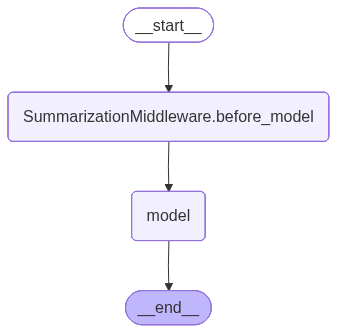

In [4]:
# 创建 Agent
agent = create_agent(
    model=chat_model,
    # 提示词可以不写, 这样也可以在调用时用 SystemMessage 来指定
    system_prompt="你是一个专业的AI助手, 请用简洁的方式回复用户的问题.",
    # 指定 checkpointer, 用于保存 StateGraph 和 短期记忆
    checkpointer=checkpointer,
    # 利用中间件来设定如何总结历史内容
    middleware=[
        SummarizationMiddleware(
            model=chat_model,
            # 触发条件, 可以有多种写法
            # ("messages", 50) -> 当 messages 数量达到50条时触发摘要生成
            # ("tokens", 3000) -> 当tokens 达到3000个时触发摘要生成
            # [("fraction", 0.8), ("messages", 100)] -> 当模型 max_tokens 达到 80% 或 messages 数量达到100条时触发摘要生成
            trigger=("tokens", 1024),
            # 触发摘要后的上下文保存策略
            # ("messages", 20) -> 保存最近20条 messages
            # ("tokens", 3000) -> 保存最近 3000 tokens
            # ("fraction", 0.3) -> 保存模型 max_tokens 的 30%
            keep=("messages", 4),
        ),
    ],
)
agent

### Step4 - 调用智能体

In [ ]:
# 方法1: 非流式调用
response = agent.invoke(
    {"messages":[HumanMessage("1+1=?")]},
    config=config,
)
for msg in response["messages"]:
    msg.pretty_print()

response = agent.invoke(
    {"messages":[HumanMessage("上一个问题是什么?")]},
    config=config,
)
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

1+1=?
================================== Ai Message ==================================

1 + 1 = 2。
================================ Human Message =================================

1+1=?
================================== Ai Message ==================================

1 + 1 = 2。
================================ Human Message =================================

上一个问题是什么?
================================== Ai Message ==================================

上一个问题是你问的“1+1=?”。


In [6]:
# 方法2: 流式调用 & stream_mode 为 values
for chunk in agent.stream(
    ({"messages":[HumanMessage("1+1=?")]}),
    config=config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

for chunk in agent.stream(
    ({"messages":[HumanMessage("上一个问题是什么?")]}),
    config=config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

1+1=?
================================== Ai Message ==================================

1 + 1 = 2。
================================ Human Message =================================

上一个问题是什么?
================================== Ai Message ==================================

上一个问题是你问的“1+1=?”。


In [7]:
# 方法3: 流式调用 & stream_mode 为 messages
for chunk in agent.stream(
    {"messages":[HumanMessage("1+1=?")]},
    config=config,
    stream_mode="messages",
):
    if isinstance(chunk[0], AIMessageChunk):
        print(chunk[0].content, end="", flush=True)

for chunk in agent.stream(
    {"messages":[HumanMessage("上一个问题是什么?")]},
    config=config,
    stream_mode="messages",
):
    if isinstance(chunk[0], AIMessageChunk):
        print(chunk[0].content, end="", flush=True)


1 + 1 = 2。上一个问题是你问的“1+1=?”。